# Actividad 3. Altos y semáforos en un video

# to do

Esta actividad realícela en un nuevo notebook
• Defina las funciones necesarias para detectar altos y semáforos. Para cada uno agregue su respectiva etiqueta

• Utilice la función time.sleep(3) para que cuando se detecte un alto (cualquiera de los dos que aparece) en un área cercana a las llantas del automóvil, se realice una pausa de 3 segundos en el video (solo una vez).

• Agregar al final de su notebook una explicación detallada de como funciona su código y una conclusión del
#ejercicio o puede explicarlo conforme avance en el notebook (con celdas definidas con Markdown)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
import time

# Análisis para dev

In [8]:
file = 'videos/altos_semaforos.mp4'

In [9]:
#dataframe para el análisis de datos
d = {'Imagen': [], 
     'pixel_value/n': [],
     'Pass': []}
total_circles = pd.DataFrame(d)

In [10]:
#cascades
stop_cascade = cv.CascadeClassifier('datos/Stopsign_HAAR_19Stages.xml')
trafficLight_cascade = cv.CascadeClassifier('datos/TrafficLight_HAAR_16Stages.xml')

## Funciones de tratamiento de imagen

In [11]:
def hsv_convert(image):
    return cv.cvtColor(image, cv.COLOR_BGR2HSV)

In [12]:
#definimos una función que retorne la mascara para el color verde
def green_finder(image):
    
    lower_green = np.array([39,50,83])
    upper_green = np.array([91,255,255])
    
    img_hsv = hsv_convert(image)
    mask_green = cv.inRange(img_hsv, lower_green, upper_green)
    
    return mask_green

In [13]:
#definimos una función que retorne la mascara para el color amarillo
def yellow_finder(image):
    
    lower_green = np.array([42,73,44])
    upper_green = np.array([100,255,255])

    img_hsv = hsv_convert(image)
    mask = cv.inRange(img_hsv, lower_green, upper_green)
    mask_green = mask
    
    return mask_green

In [14]:
#definimos una función que retorne la mascara para el color rojo
def red_finder(image):#
    lower_red1 = np.array([0,100,100])
    upper_red1 = np.array([5,255,255])
    lower_red2 = np.array([170,100,100])
    upper_red2 = np.array([180,255,255])
    
    img_hsv = hsv_convert(image)#
    
    mask1 = cv.inRange(img_hsv, lower_red1, upper_red1)
    mask2 = cv.inRange(img_hsv, lower_red2, upper_red2)
    
    mask_red = cv.add(mask1, mask2)
    
    return mask_red

## Funciones para análisis

### Altos

In [15]:
def detector_altos(image):
    
    #convertir a escala de grises la imagen
    img_grey = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    #encontrar altos en las imágenes
    alto = stop_cascade.detectMultiScale(img_grey, 
                                         scaleFactor=1.11,
                                         minNeighbors=5,
                                         minSize=(30, 30),
                                         flags = cv.CASCADE_SCALE_IMAGE)
        
    return alto

In [16]:
def altos_printer(image):
    label = 'alto'
    
    alto = detector_altos(image)
    
    for (x,y,w,h) in alto: #dibuja un rectangulo por cada alto que encuentre y pone etiqueta
        cv.rectangle(image, (x,y), (x+w,y+h), (255,0,0), 2)
        Y = y - 15 if y - 15 > 15 else y + 15
        cv.putText(image, label, (x, Y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv.LINE_AA)
        
#    return cv.cvtColor(image, cv.COLOR_BGR2RGB)    #regresa la imagen dibujada

### Semaforos

In [17]:
def circle_finder(img):
    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1, 30, param1 = 50, param2 = 5, minRadius = 0, maxRadius = 30)
    return circles

In [18]:
def print_circle(image, color_mask, label):
    
    #Estética de escritura
    font = cv.FONT_HERSHEY_SIMPLEX
    region = 5
    
    #Circulos
    circles = circle_finder(color_mask)

    #Entra si existe un circulo
    if circles is not None:
        circles = np.uint16(np.around(circles))
        
        #Para cada circulo
        for i in circles[0, :]:
            pixel_value = 0.0
            n = 0.0
            check = False
            
            for j in range(-region, region):
                for k in range(-region, region):
                    pixel_value += color_mask[i[1]+j, i[0]+k]
                    n += 1

            
            if pixel_value/n > 50:
                cv.circle(image, (i[0], i[1]), i[2]+10, (0,255,0), 2)
                cv.putText(image, label, (i[0]-i[2], i[1]-i[2]-10), font, 1, (0, 255, 0), 2, cv.LINE_AA)
    
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

In [19]:
def circle_writer(original_image):
        
    #print('-----------------------------------------')
    
    #Encontrar la mascara verde
    green_mask = green_finder(original_image)
    green_label = 'Verde'
    original_image = print_circle(original_image, green_mask, green_label)

    
    return cv.cvtColor(original_image, cv.COLOR_BGR2RGB)

## Video

In [20]:
video = cv.VideoCapture(file)

cv.startWindowThread()

while(video.isOpened()):
    
    time.sleep(.0001)
    ret, frame = video.read()
    alto = frame.shape[0]
    ancho = frame.shape[1]
    ratio = 0.8
    frame = cv.resize(frame, ( int(ancho*ratio) , int(alto*ratio) ), interpolation=cv.INTER_NEAREST )
    
    if ret:
        
        #deteccion de semadoro en VERDE
        green_mask = green_finder(frame)
        #semaforo_verde = print_circle(frame, green_mask, 'Verde')
        #RGB_fix = cv.cvtColor(semaforo_verde, cv.COLOR_BGR2RGB)
        cv.imshow("green_mask", green_mask)
        
        #deteccion de semadoro en AMARILLO
        yellow_mask = yellow_finder(frame)
        #semaforo_amarillo = print_circle(frame, yellow_mask, 'Amarillo')
        #RGB_fix = cv.cvtColor(semaforo_amarillo, cv.COLOR_BGR2RGB)
        cv.imshow("yellow_mask ", yellow_mask)
        
        #deteccion de semadoro en ROJO
        red_mask = red_finder(frame)
        semaforo_rojo = print_circle(frame, red_mask, 'Rojo')
        RGB_fix = cv.cvtColor(semaforo_rojo, cv.COLOR_BGR2RGB)
        cv.imshow("red_mask", RGB_fix)
        
        #detección de altos
        altos_printer(frame)
        cv.imshow("video con altos", frame)
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            print('q')
            break            
            
    else:
        break

cv.waitKey(5000)
        
cv.waitKey(1)

cv.destroyAllWindows()

video.release()

cv.waitKey(1)

<ipython-input-12-c3394edb5f5f>:28: RuntimeWarning: overflow encountered in ushort_scalars
  cv.putText(image, label, (i[0]-i[2], i[1]-i[2]-10), font, 1, (0, 255, 0), 2, cv.LINE_AA)


AttributeError: 'NoneType' object has no attribute 'shape'

# Análsis de algunas imágenes

In [5]:
vidcap = cv.VideoCapture(file)
success,image = vidcap.read()
count = 0
while success:
    cv.imwrite("all_frames/stop_test_frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count +=1


Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

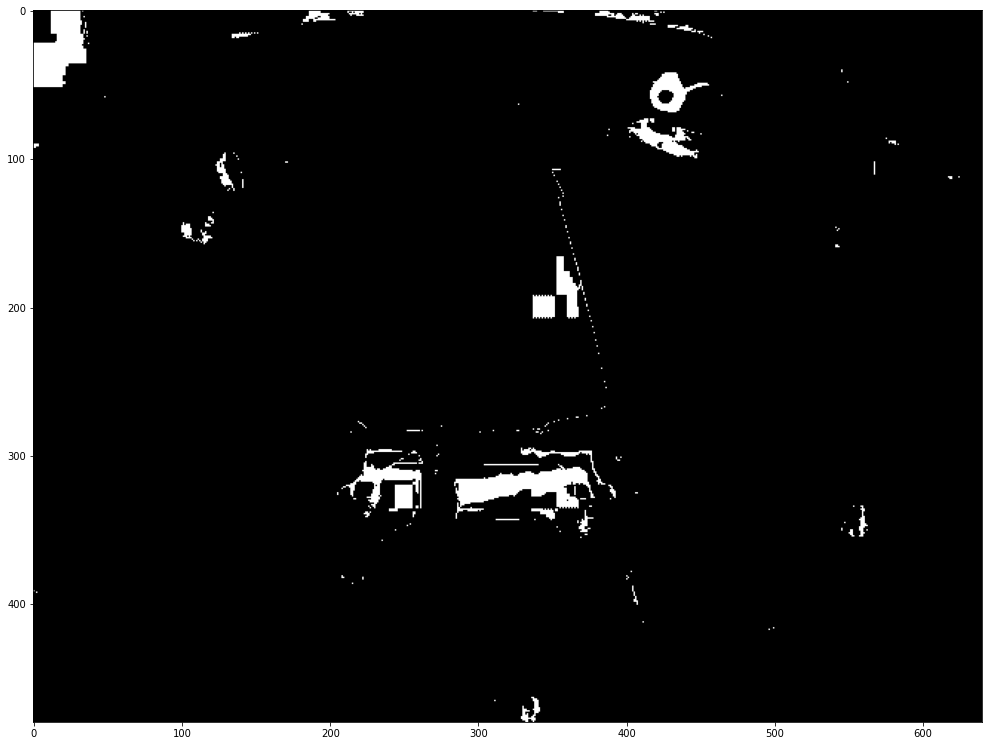

In [31]:
img_stop_test = cv.imread('all_frames/stop_test_frame156.jpg', cv.COLOR_BGR2RGB)
img_stop_test = green_finder(img_stop_test)
RGB_img = cv.cvtColor(img_stop_test, cv.COLOR_BGR2RGB)
plt.figure(figsize=(17,17))
plt.imshow(RGB_img)